# AllLifeBank Customer Segmentation

## Description:
### Context:
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help
Objective: To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

#### Data Description: 
Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.


pip install yellowbrick

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

import scipy.stats as stats
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet
from sklearn.cluster import AgglomerativeClustering 


# Removes the limit from the number of displayed columns and rows.
# This is so I can see the entire dataframe when I print it
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', 300)

### Read the Dataset

In [2]:
data= pd.read_excel(r'/Users/srujana/Downloads/Credit Card Customer Data.xlsx')

In [3]:
# copying data to another varaible to avoid any changes to original data
CreditCardData=data.copy()

### View the first and last 5 rows of the dataset.

In [4]:
CreditCardData.head()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0      1         87073            100000                   2   
1      2         38414             50000                   3   
2      3         17341             50000                   7   
3      4         40496             30000                   5   
4      5         47437            100000                   6   

   Total_visits_bank  Total_visits_online  Total_calls_made  
0                  1                    1                 0  
1                  0                   10                 9  
2                  1                    3                 4  
3                  1                    1                 4  
4                  0                   12                 3

In [5]:
CreditCardData.tail()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
655    656         51108             99000                  10   
656    657         60732             84000                  10   
657    658         53834            145000                   8   
658    659         80655            172000                  10   
659    660         80150            167000                   9   

     Total_visits_bank  Total_visits_online  Total_calls_made  
655                  1                   10                 0  
656                  1                   13                 2  
657                  1                    9                 1  
658                  1                   15                 0  
659                  0                   12                 2

### Understand the shape of the dataset.

In [6]:
CreditCardData.shape

(660, 7)

In [7]:
print(f'Dataset has {CreditCardData.shape[0]} rows and {CreditCardData.shape[1]} columns.')  # f-string

Dataset has 660 rows and 7 columns.


### Check the data types of the columns for the dataset.

In [8]:
CreditCardData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [9]:
CreditCardData.columns = CreditCardData.columns.str.replace(' ', '_')

## Count the datatypes

In [10]:
#count the number of variables in each datatype
CreditCardData.dtypes.value_counts()

int64    7
dtype: int64

## Verify the duplicate records row wise

In [11]:
sum(CreditCardData.duplicated())

0

In [12]:
from pandas_profiling import ProfileReport

profile = ProfileReport(CreditCardData)
# to view report created by pandas profile
profile

### Summary of the dataset

In [13]:
 CreditCardData.describe(include="all")  

Sl_No  Customer_Key  Avg_Credit_Limit  Total_Credit_Cards  \
count  660.000000    660.000000        660.000000          660.000000   
mean   330.500000  55141.443939      34574.242424            4.706061   
std    190.669872  25627.772200      37625.487804            2.167835   
min      1.000000  11265.000000       3000.000000            1.000000   
25%    165.750000  33825.250000      10000.000000            3.000000   
50%    330.500000  53874.500000      18000.000000            5.000000   
75%    495.250000  77202.500000      48000.000000            6.000000   
max    660.000000  99843.000000     200000.000000           10.000000   

       Total_visits_bank  Total_visits_online  Total_calls_made  
count         660.000000           660.000000        660.000000  
mean            2.403030             2.606061          3.583333  
std             1.631813             2.935724          2.865317  
min             0.000000             0.000000          0.000000  
25%             1.000000             1.000000          1.000000  
50%             2.000000             2.000000          3.000000  
75%             4.000000             4.000000          5.000000  
max             5.000000            15.000000         10.000000

Observations:
- Avg_Credit_Limit ranges from 3000 to 200000 with the mean at 34574.242424 and the median value at 18000. This shows that Avg_Credit_Limit is highly right skewed.
- Total_Credit_Cards variable ranges from 1-10 cards per customer, with mean at 4.7 and median at 2.
- Total_visits_bank variable ranges from 0-5 visits with mean at 2.4 and median at 2.
- Total_visits_online ranges from 0-15, with mean at 2.6, median at 2. The first quantile is 1 and third quantile 4 while the maximum visits is 15. This indicates that there are some outliers in this variable.
- Total_calls_made ranges from 0-10, with mean at 3.5 and median at 3. 
- The average of Total_calls_made is higher than Total_visits_bank and Total_visits_online.

In [14]:
# checking for unique values in Customer Key column
CreditCardData["Customer_Key"].nunique()

655

There are 660 records in the dataset and 655 unique customer key records.So, there must be 5 dupliacte records.

In [15]:
# Verifying the column level duplicates
CreditCardData["Customer_Key"].duplicated().sum()

5

In [16]:
# Extract duplicate rows
CreditCardData.loc[CreditCardData["Customer_Key"].duplicated(keep=False), :].sort_values(by="Customer_Key", ascending=False)

Sl_No  Customer_Key  Avg_Credit_Limit  Total_Credit_Cards  \
104    105         97935             17000                   2   
632    633         97935            187000                   7   
391    392         96929             13000                   4   
398    399         96929             67000                   6   
411    412         50706             44000                   4   
541    542         50706             60000                   7   
4        5         47437            100000                   6   
332    333         47437             17000                   7   
48      49         37252              6000                   4   
432    433         37252             59000                   6   

     Total_visits_bank  Total_visits_online  Total_calls_made  
104                  1                    2                10  
632                  1                    7                 0  
391                  5                    0                 0  
398                  2                    2                 2  
411                  5                    0                 2  
541                  5                    2                 2  
4                    0                   12                 3  
332                  3                    1                 0  
48                   0                    2                 8  
432                  2                    1                 2

#### Let's drop those duplicates.

In [17]:
CreditCardData = CreditCardData[(~CreditCardData["Customer_Key"].duplicated())].copy()

In [18]:
CreditCardData.shape

(655, 7)

In [19]:
# checking for unique values in Sl_No column
CreditCardData["Sl_No"].nunique()

655

In [20]:
CreditCardData.drop(["Sl_No"],axis=1,inplace=True)

In [21]:
# checking for unique values in Customer Key column
CreditCardData["Customer_Key"].nunique()

655

In [22]:
CreditCardData["Customer_Key"].duplicated().sum()

0

CreditCardData.drop(["Customer_Key"],axis=1,inplace=True)

In [23]:
CreditCardData.head()

Customer_Key  Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0         87073            100000                   2                  1   
1         38414             50000                   3                  0   
2         17341             50000                   7                  1   
3         40496             30000                   5                  1   
4         47437            100000                   6                  0   

   Total_visits_online  Total_calls_made  
0                    1                 0  
1                   10                 9  
2                    3                 4  
3                    1                 4  
4                   12                 3

In [24]:
CreditCardData[(CreditCardData.Total_visits_online == 0)].iloc[:,1:].describe().T

count          mean           std     min      25%  \
Avg_Credit_Limit     144.0  35131.944444  22971.324943  5000.0  13750.0   
Total_Credit_Cards   144.0      5.534722      1.211329     4.0      4.0   
Total_visits_bank    144.0      3.506944      1.176676     2.0      2.0   
Total_visits_online  144.0      0.000000      0.000000     0.0      0.0   
Total_calls_made     144.0      2.069444      1.475453     0.0      1.0   

                         50%      75%      max  
Avg_Credit_Limit     35000.0  56000.0  75000.0  
Total_Credit_Cards       6.0      7.0      7.0  
Total_visits_bank        3.5      5.0      5.0  
Total_visits_online      0.0      0.0      0.0  
Total_calls_made         2.0      3.0      4.0

In [25]:
CreditCardData[(CreditCardData.Total_visits_bank == 0)].iloc[:,1:].describe().T

count      mean           std     min     25%      50%  \
Avg_Credit_Limit     100.0  39150.00  56004.035749  3000.0  9000.0  14000.0   
Total_Credit_Cards   100.0      3.54      2.698372     1.0     2.0      3.0   
Total_visits_bank    100.0      0.00      0.000000     0.0     0.0      0.0   
Total_visits_online  100.0      5.03      3.616614     1.0     3.0      4.0   
Total_calls_made     100.0      5.82      3.085908     0.0     4.0      6.0   

                         75%       max  
Avg_Credit_Limit     20000.0  200000.0  
Total_Credit_Cards       4.0      10.0  
Total_visits_bank        0.0       0.0  
Total_visits_online      5.0      15.0  
Total_calls_made         8.0      10.0

In [26]:
CreditCardData[(CreditCardData.Total_calls_made == 0)].iloc[:,1:].describe().T

count          mean           std     min      25%  \
Avg_Credit_Limit      95.0  53536.842105  48632.536724  6000.0  15500.0   
Total_Credit_Cards    95.0      5.957895      1.719202     2.0      4.5   
Total_visits_bank     95.0      3.010526      1.512323     0.0      2.0   
Total_visits_online   95.0      2.557895      4.109449     0.0      0.0   
Total_calls_made      95.0      0.000000      0.000000     0.0      0.0   

                         50%      75%       max  
Avg_Credit_Limit     41000.0  69500.0  200000.0  
Total_Credit_Cards       6.0      7.0      10.0  
Total_visits_bank        3.0      4.0       5.0  
Total_visits_online      1.0      2.0      15.0  
Total_calls_made         0.0      0.0       0.0

In [27]:
CreditCardData.Total_visits_online.sum()

1707

In [28]:
CreditCardData.Total_visits_bank.sum()

1573

In [29]:
CreditCardData.Total_calls_made.sum()

2359

### Univariate analysis

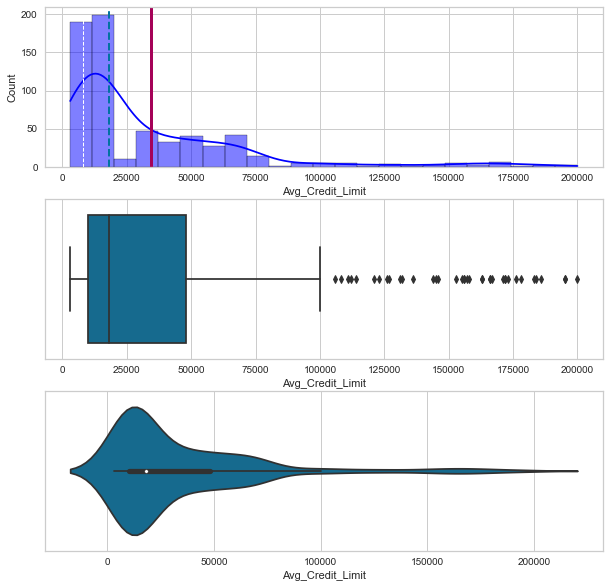

In [30]:
#View the distribution of the Avg_Credit_Limit variable
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
sns.histplot(x=CreditCardData.Avg_Credit_Limit,color="blue",kde=True);
plt.axvline(CreditCardData["Avg_Credit_Limit"].mean(),color='m',linewidth=3)# draw a line indicating mean
plt.axvline(CreditCardData["Avg_Credit_Limit"].median(),color='b',linestyle='dashed',linewidth=2)# draw a line indicating median
plt.axvline(CreditCardData["Avg_Credit_Limit"].mode()[0],color='w',linestyle='dashed',linewidth=1)# draw a line indicating mode
plt.subplot(3,1,2)
sns.boxplot(x=CreditCardData.Avg_Credit_Limit);
plt.subplot(3,1,3)
sns.violinplot(x=CreditCardData.Avg_Credit_Limit);

Observations:
- The Avg_Credit_Limit of a customer varies from 3000 to 200000.
- Avg_Credit_Limit is highly righly skewed.
- There are lot of outliers to the right.
- The mean of Avg_Credit_Limit is 34574 while the median is 18000.
- The 3rd quantile value is at 48000 while the first quantile value is at 10000 and the median is at 18000.
- Majority of the customers have Avg_Credit_Limit lesser than the median value-18000.
- There are quite some customers whose average credit limit is higher than 100000.

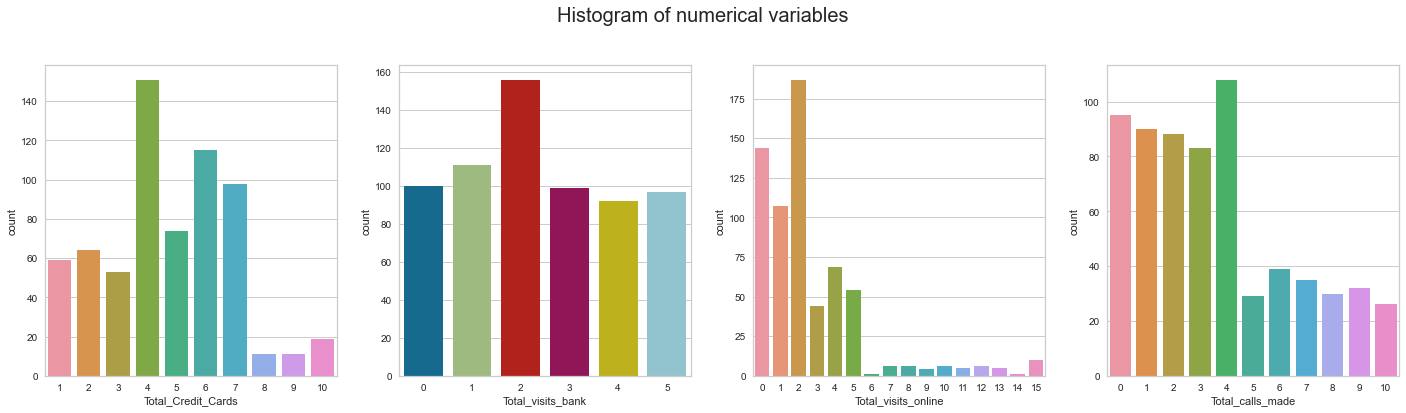

In [31]:
all_col = CreditCardData.iloc[:,1:].columns.tolist()
all_cat_col = CreditCardData.iloc[:,2:].columns.tolist()
fig, axes = plt.subplots(1, 4,  figsize=(20, 6))
fig.suptitle('Histogram of numerical variables', fontsize=20)
counter = 0
for ii in range(4):
    sns.countplot(ax=axes[ii],x=CreditCardData[all_cat_col[counter]])
    counter = counter+1

fig.tight_layout(pad=2.0)

Observations:
- There are more customers who have 4 to 7 credit cards.
- 67.18% of customers made atleast 2 visits to the bank.
- Most of the customers have made atleast 2 visits online.
- Most of the customers have made 4 calls to the bank.

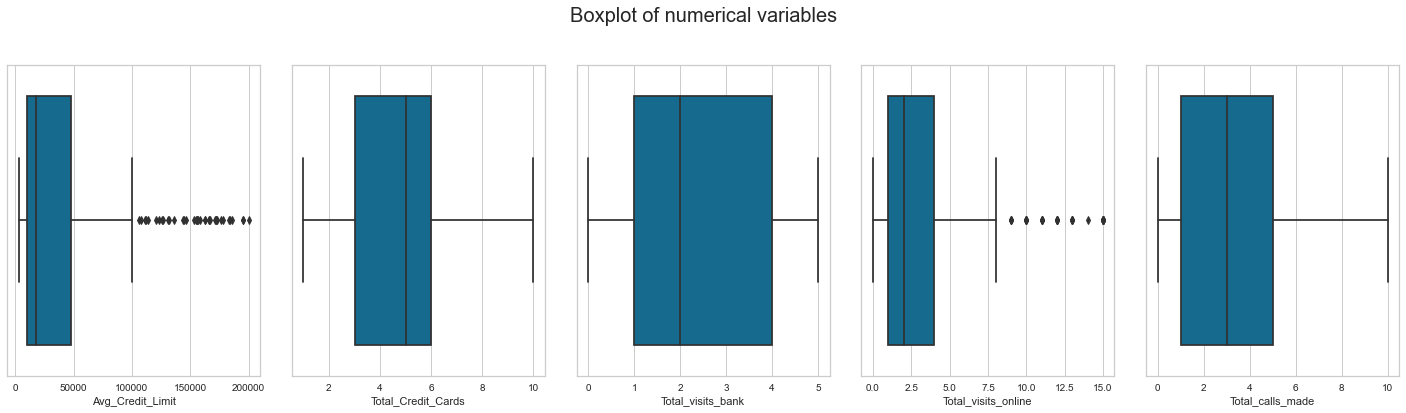

In [32]:
fig, axes = plt.subplots(1, 5,  figsize=(20, 6))
fig.suptitle('Boxplot of numerical variables', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],x=CreditCardData[all_col[counter]])
    counter = counter+1

fig.tight_layout(pad=2.0)

Observations:
- There are upper ouliers in the Avg_Credit_Limit which indicates that the credit limit of few customers is very high.
- 50% of the customers have Avg_Credit_Limit lesser than 18000 while the max is 200000. 
- 50% of the customers have atleast 3-6 credit cards.
- 50% of the customers have made 2 visits to the bank.
- There are upper ouliers in the Total_visits_online which indicates that those customers preferred mode of querying the bank is through online, for various reasons. Probably the customers didnt get the satisfactory respone and that is why they are making multiple calls to the bank's customer support.
- 75% of the customers have made upto 4 visits online while the max is 15 visits.
- 75% of the customers have made 5 calls and the max is 10 calls.

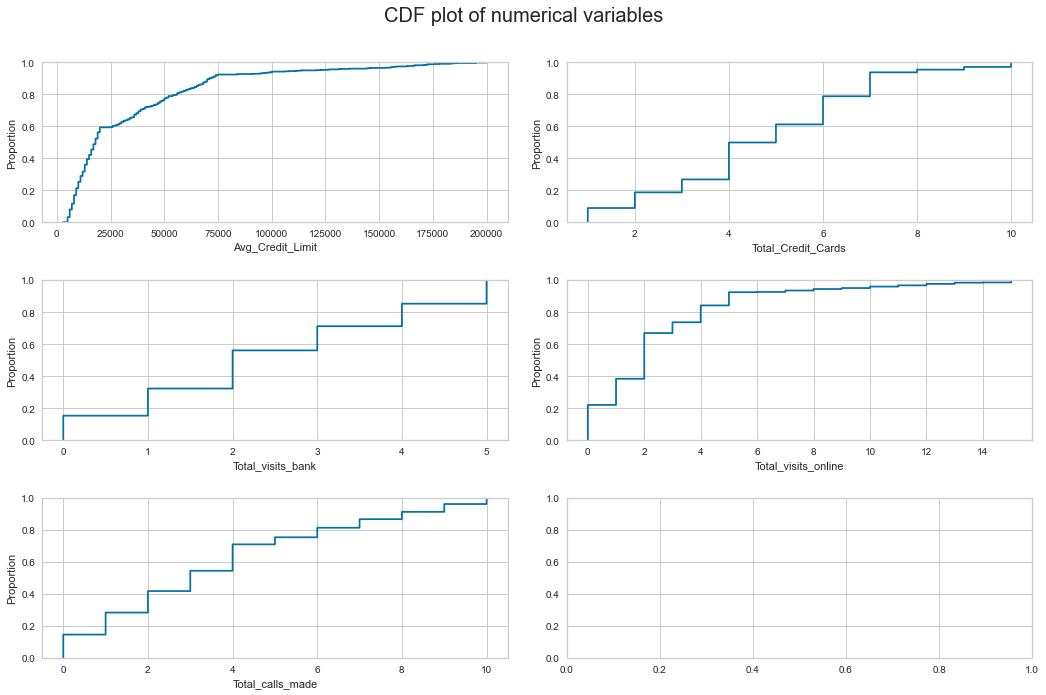

In [33]:
# select numerical columns

fig, axes = plt.subplots(3, 2,  figsize=(15, 10))
fig.suptitle('CDF plot of numerical variables', fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0],x=CreditCardData[all_col[counter]])
    counter = counter+1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1],x=CreditCardData[all_col[counter]])
        counter = counter+1
    else:
        pass


fig.tight_layout(pad=2.0)

Observations:
- We notice that around 90% of the customers have  average credit limit below 75000.
- 60% of the customers have atmost 6 credit cards.
- 90% of the customers have made 5 visits online.
- 80% of the customers have made 6 calls to the bank for enquiries.
- 50% of the customers have made 2 visits to the bank.

### Bivariate Analsysis

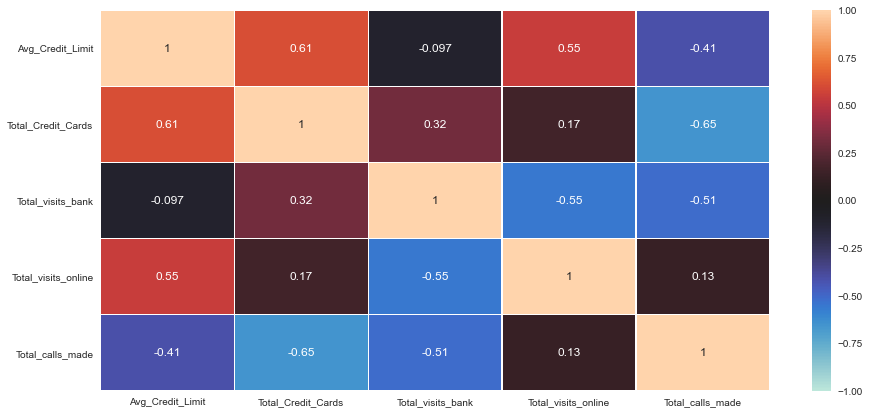

In [34]:
plt.figure(figsize=(15,7))

sns.heatmap(CreditCardData[all_col].corr(),
            annot=True,
            linewidths=0.5,vmin=-1,vmax=1,
            center=0,
            cbar=True,)

plt.show()

Observations:
- Avg_Credit_Limit has strong positive correlation with Total_Credit_Cards and Total_Visits_Online and negative correlation with Total_calls_made.
- Total_Credit_Cards has strong positive correlation with Avg_Credit_Limit and negative correlation with Total_calls_made.
- Total_Visits_bank has strong negative correlation with Total_calls_made and Total_Visits_Online

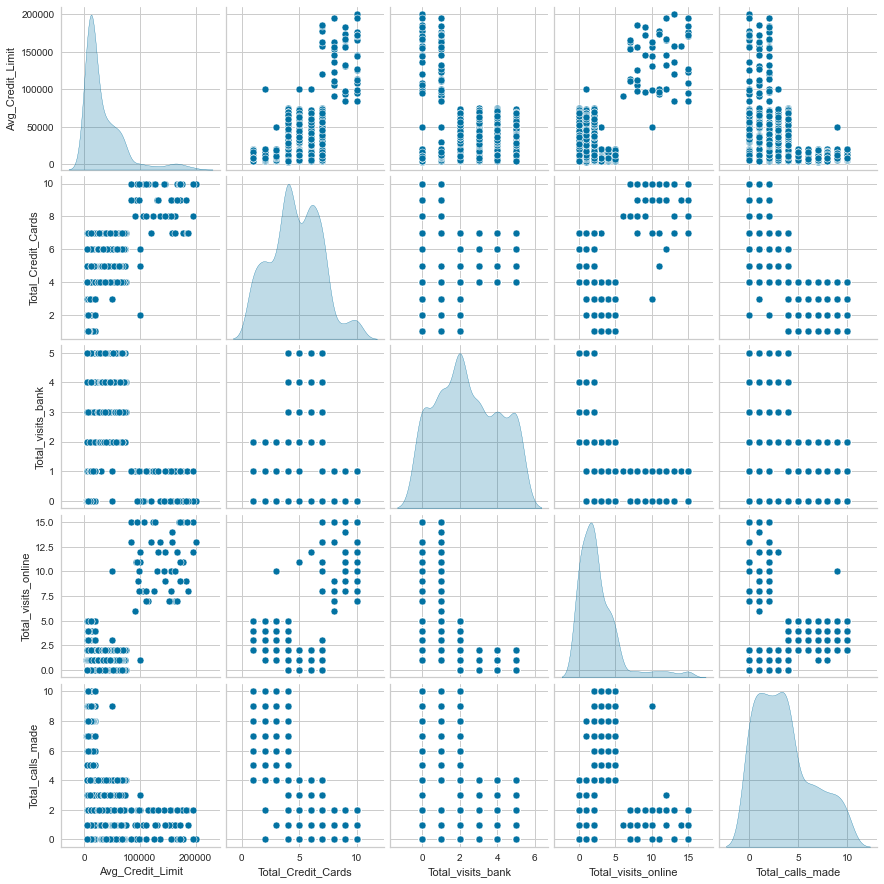

In [35]:
sns.pairplot(CreditCardData[all_col],diag_kind="kde");

- We notice that Avg_Credit_Limit is showing a linear relationship with Total_Credit_Cards and Total_visits_online.
- From the pair plot, we see that there are atleast 2 peaks for some of the variables, which indicates that there would be a minimum of 2 clsuters.

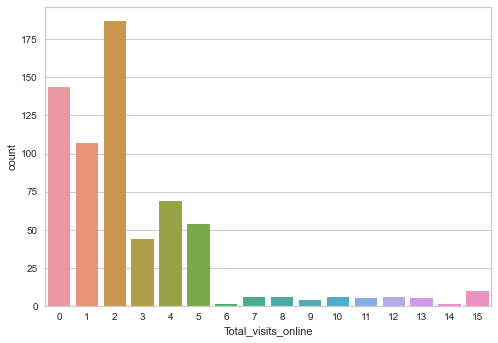

In [36]:
sns.countplot(x='Total_visits_online',data=CreditCardData);

Observations:
- There are more customers(28.8%) who made 2 visits online for queries.
- There are atleast 20% of the customers who donot prefer to make online enqueries.

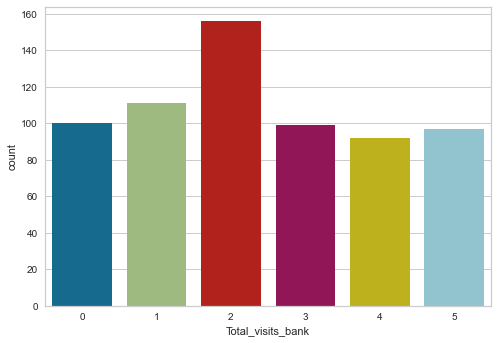

In [37]:
sns.countplot(x='Total_visits_bank',data=CreditCardData);

Observations:
- There are more customers(24%) who visit the bank twice.
- There are atleast 15% of the customers who donot prefer to visit the bank for enquiries.

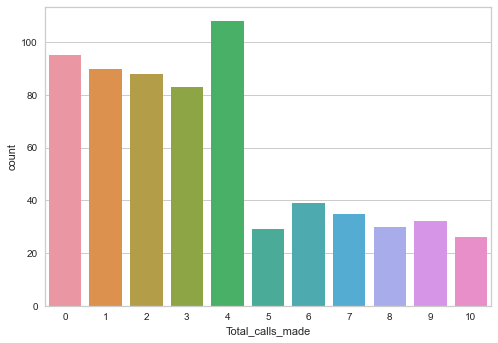

In [38]:
sns.countplot(x='Total_calls_made',data=CreditCardData);

Observations:
- There are more customers(16%) who made 4 calls to the bank for queries.
- There are atleast 14.8% of the customers who donot prefer to make calls to the bank for enquiries.

In [39]:
CreditCardData.groupby(["Total_Credit_Cards"])['Avg_Credit_Limit'].mean()

Total_Credit_Cards
1      11457.627119
2      13187.500000
3      13301.886792
4      26311.258278
5      34689.189189
6      32686.956522
7      43163.265306
8     139454.545455
9     140090.909091
10    136842.105263
Name: Avg_Credit_Limit, dtype: float64

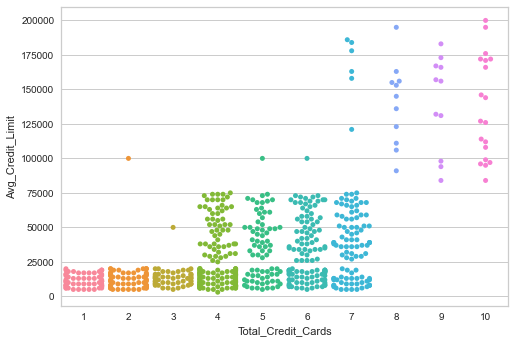

In [40]:
sns.swarmplot(x='Total_Credit_Cards',y='Avg_Credit_Limit',data=CreditCardData);

Observations:
- We notoice a positive correlation between Total_Credit_Cards and Avg_Credit_Limit.
- Greater the number of cards, the higher the credit limit.

In [41]:
CreditCardData.groupby(["Total_Credit_Cards"])['Total_visits_bank'].mean()

Total_Credit_Cards
1     0.932203
2     0.921875
3     0.867925
4     2.768212
5     3.256757
6     3.582609
7     3.214286
8     0.636364
9     0.727273
10    0.631579
Name: Total_visits_bank, dtype: float64

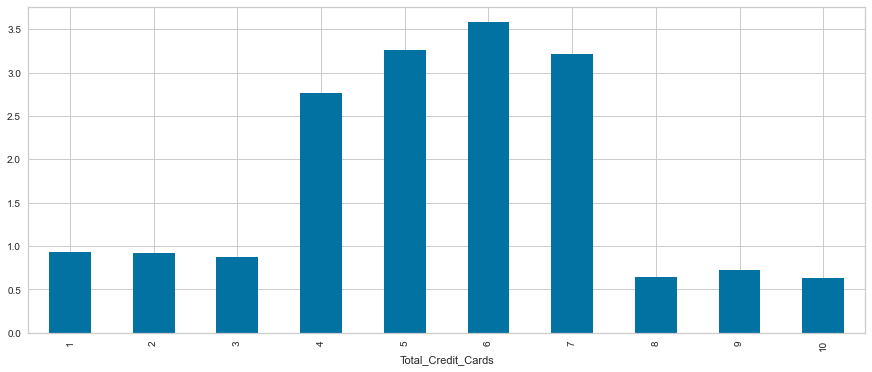

In [42]:
CreditCardData.groupby(["Total_Credit_Cards"])['Total_visits_bank'].mean().plot.bar(figsize=(15,6));

Observations:
- Customers with 4-7 cards have made more visits to the bank, followed by the customers who owned 1 – 3 cards.
- Customers with 8-10 cards made the least number of personal visits to the bank. 

In [43]:
CreditCardData.groupby(["Total_Credit_Cards"])['Total_visits_online'].mean()

Total_Credit_Cards
1      3.491525
2      3.531250
3      3.698113
4      1.728477
5      1.216216
6      1.156522
7      1.530612
8      9.272727
9     11.272727
10    11.526316
Name: Total_visits_online, dtype: float64

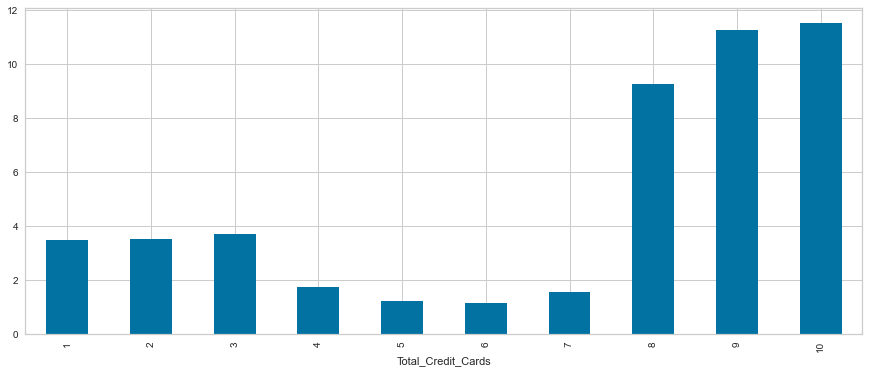

In [44]:
CreditCardData.groupby(["Total_Credit_Cards"])['Total_visits_online'].mean().plot.bar(figsize=(15,6));

Observations:
- Customers with 8-10 cards have made more online visits to the bank for enquiries.
- Customers with 1-3 cards made on an average 3 online visits to the bank for enquiries.
- Customers with 4-7 cards have made least number of online visits(one on an average) to the bank.

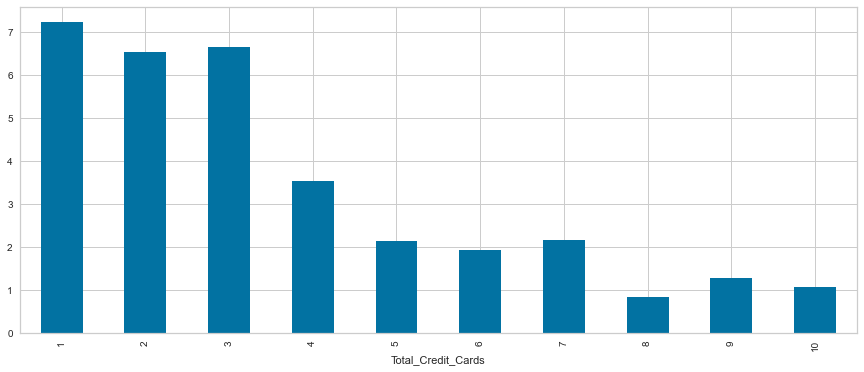

In [45]:
import matplotlib.pyplot as plt
CreditCardData.groupby(["Total_Credit_Cards"])['Total_calls_made'].mean().plot.bar(figsize=(15,6));

Observations:
- Customers with 1-3 cards have made more calls compared to others.

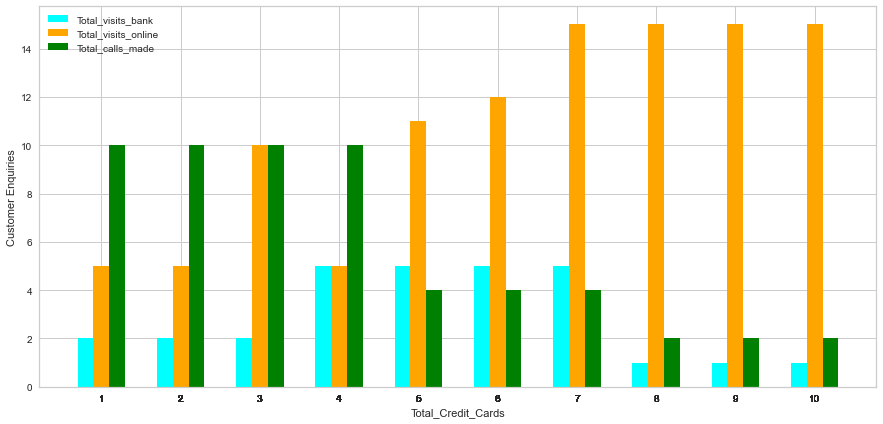

In [46]:
plt.figure(figsize=(15,7))
width = 0.2
y1=CreditCardData['Total_visits_bank']
y2= CreditCardData['Total_visits_online']
y3=CreditCardData['Total_calls_made']
x = CreditCardData["Total_Credit_Cards"]
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='green')
plt.xticks(x)
plt.xlabel("Total_Credit_Cards")
plt.ylabel("Customer Enquiries")
plt.legend(["Total_visits_bank", "Total_visits_online", "Total_calls_made"])
plt.show()

### Treating Outliers

### Lets look at outliers in every numerical column

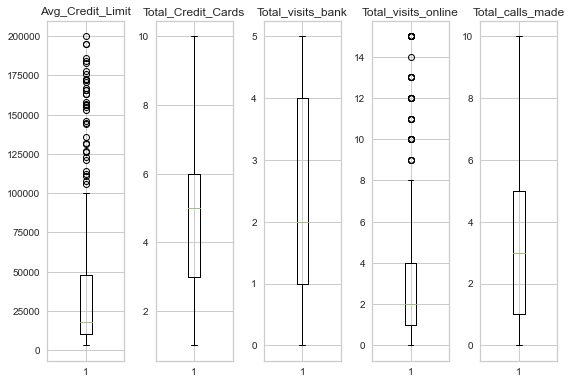

In [47]:
# lets look at box plot to see the outliers 


for i, variable in enumerate(all_col):
                     plt.subplot(1,5,i+1)
                     plt.boxplot(CreditCardData[variable],whis=1.5)
                     plt.tight_layout()
                     plt.title(variable)

plt.show()

In [48]:
# Lets treat outliers by flooring and capping them at 1.5IQR
def treat_outliers(df,col):
    '''
    treats outliers in a varaible
    col: str, name of the numerical varaible
    df: data frame
    col: name of the column
    '''
    Q1=df[col].quantile(0.25) # 25th quantile
    Q3=df[col].quantile(0.75)  # 75th quantile
    IQR=Q3-Q1
    Lower_Whisker = Q1 - 1.5*IQR 
    Upper_Whisker = Q3 + 1.5*IQR
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker 
                                                            # and all the values above upper_whishker will be assigned value of upper_Whisker 
    return df

def treat_outliers_all(df, col_list):
    '''
    treat outlier in all numerical varaibles
    col_list: list of numerical varaibles
    df: data frame
    '''
    for c in col_list:
        df = treat_outliers(df,c)
        
    return df
    

In [49]:
CreditCardData = treat_outliers_all(CreditCardData,['Avg_Credit_Limit'])

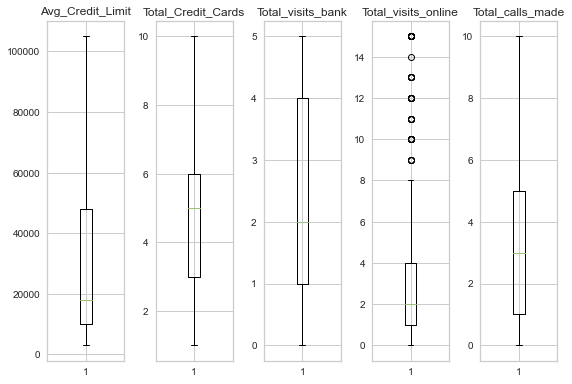

In [50]:
# lets look at box plot to see if outliers has been treated or not
for i, variable in enumerate(all_col):
                     plt.subplot(1,5,i+1)
                     plt.boxplot(CreditCardData[variable],whis=1.5)
                     plt.tight_layout()
                     plt.title(variable)

plt.show()

- We capped the values at 1.5IQR for only Avg_Credit_Limit column as it is a continuous variable.
- The outliers in Total_visits_online variable are not treated as its values are discrete in nature.

### Scaling the data

In [51]:
# Scaling the data set before clustering
scaler=StandardScaler()
subset=CreditCardData[all_col].copy()
subset_scaled=scaler.fit_transform(subset)   

In [52]:
#Creating a dataframe from the scaled data above
subset_scaled_df=pd.DataFrame(subset_scaled,columns=subset.columns)

# K-Means Clustering

Number of Clusters: 1 	Average Distortion: 2.044353007149101
Number of Clusters: 2 	Average Distortion: 1.4852012536807688
Number of Clusters: 3 	Average Distortion: 1.181814885591652
Number of Clusters: 4 	Average Distortion: 1.068764130286178
Number of Clusters: 5 	Average Distortion: 1.001040175708282
Number of Clusters: 6 	Average Distortion: 0.9457438878566461
Number of Clusters: 7 	Average Distortion: 0.9089677516685918
Number of Clusters: 8 	Average Distortion: 0.8858755977587838


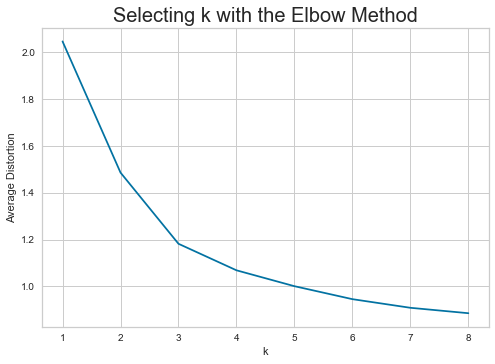

In [53]:
clusters=range(1,9)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction=model.predict(subset_scaled_df)
    distortion=sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / subset_scaled_df.shape[0]
                           
    meanDistortions.append(distortion)

    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=20);

#### From Elbow method, 3 can be a good value for K

## Lets us check silhoutte score

In [54]:
sil_score = []
cluster_list = list(range(2,10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    #centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.41388548264460095)
For n_clusters = 3, silhouette score is 0.5075035671327102)
For n_clusters = 4, silhouette score is 0.379950520643679)
For n_clusters = 5, silhouette score is 0.3509917483509575)
For n_clusters = 6, silhouette score is 0.2732695139477488)
For n_clusters = 7, silhouette score is 0.26771861321438306)
For n_clusters = 8, silhouette score is 0.25009707498277794)
For n_clusters = 9, silhouette score is 0.2355964429215702)


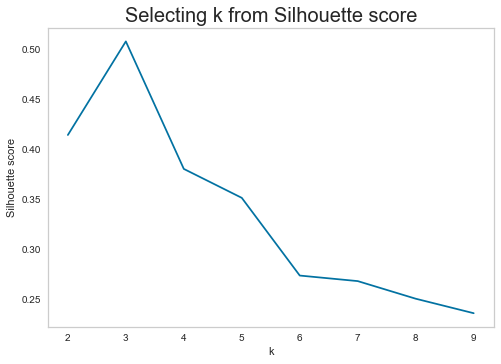

In [55]:
plt.plot(cluster_list,sil_score)
plt.grid()
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Selecting k from Silhouette score', fontsize=20);

From silhouette score, it seems that 3 is good value of k

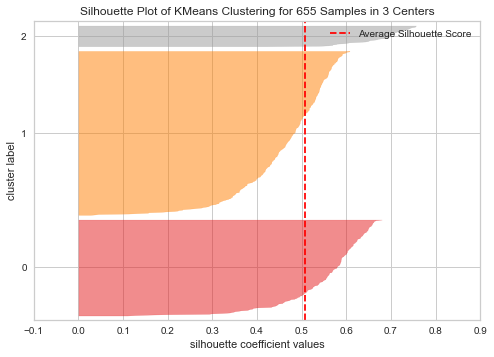

In [56]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show();

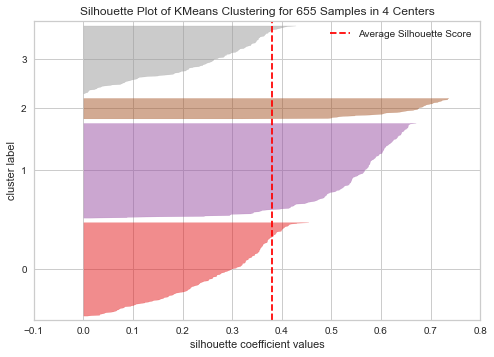

In [57]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show();

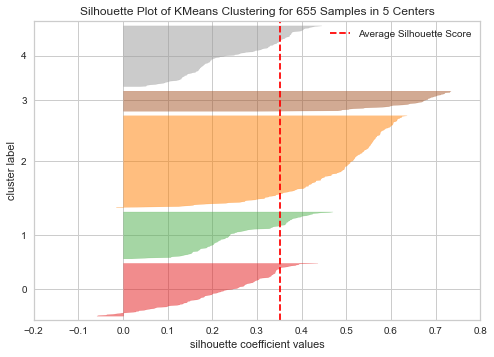

In [58]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show();

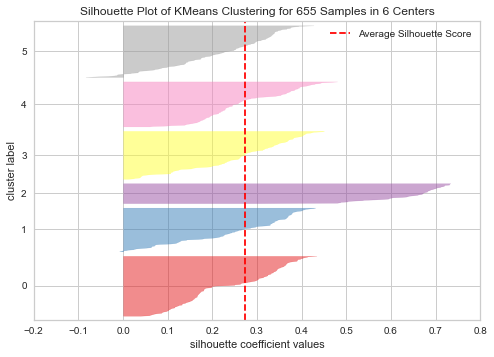

In [59]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show();

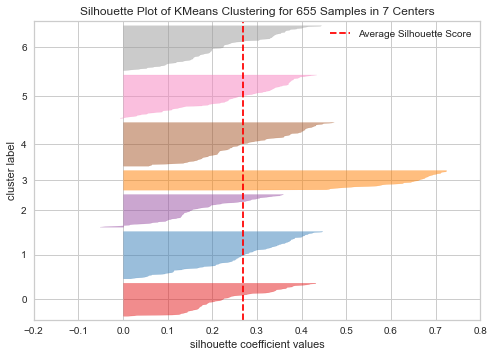

In [60]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show();

Let us take 3 as appropriate no. of clusters as silhoutte score is high enough and also there is a knick at 3 in elbow curve.

In [61]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=0)

In [62]:
CreditCardData['K_means_segments'] = kmeans.labels_
subset_scaled_df['K_means_segments'] = kmeans.labels_

In [63]:
cluster_profile = CreditCardData.iloc[:,1:].groupby('K_means_segments').mean()

In [64]:
cluster_profile['count_in_each_segment'] = CreditCardData.groupby('K_means_segments')['Total_Credit_Cards'].count().values

In [65]:
cluster_profile.style.highlight_max(color = 'lightgreen', axis = 0)

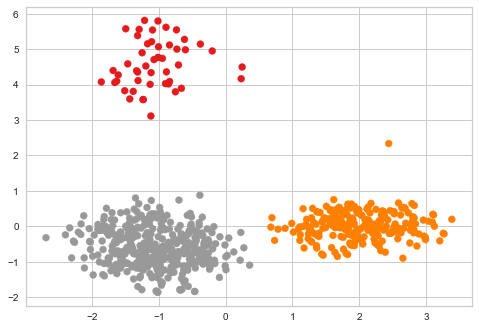

In [66]:
from sklearn.decomposition import PCA
import pylab as pl
pca=PCA(n_components=3).fit(subset_scaled_df)
pca_2d=pca.transform(subset_scaled_df)
pl.figure("k-means with 3 clusters")
pl.scatter(pca_2d[:,0],pca_2d[:,1],c=kmeans.labels_,cmap='Set1')
pl.show();

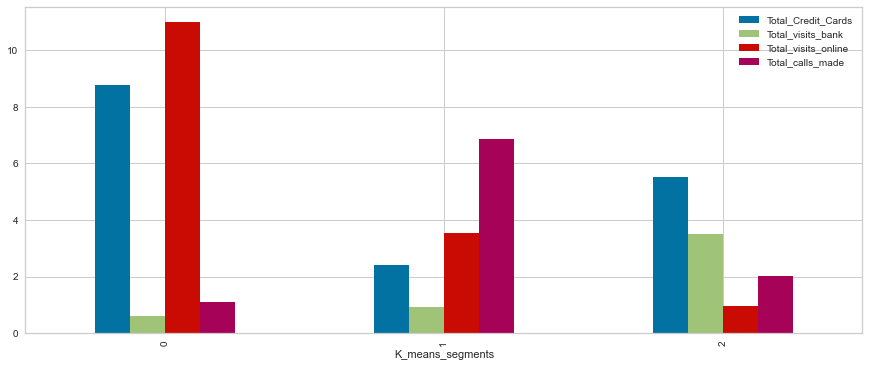

In [67]:
CreditCardData.iloc[:,2:].groupby('K_means_segments').mean().plot.bar(figsize=(15,6));

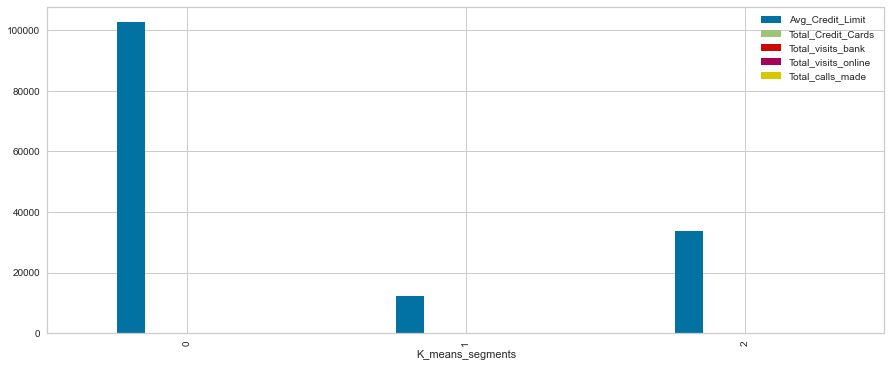

In [68]:
CreditCardData.iloc[:,1:].groupby('K_means_segments').mean().plot.bar(figsize=(15,6));

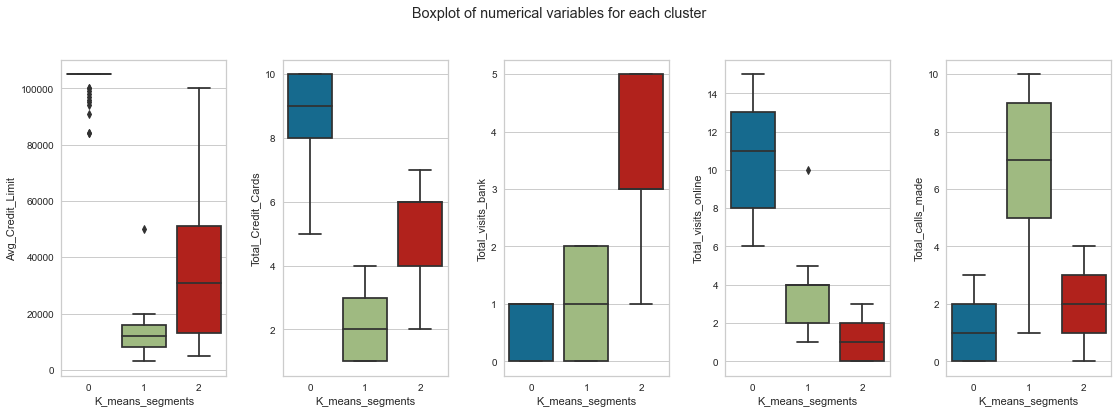

In [69]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster')
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=CreditCardData[all_col[counter]],x=CreditCardData['K_means_segments'])
    counter = counter+1

fig.tight_layout(pad=2.0)

#### Compare Cluster vs Total_Credit_Cards

In [70]:
pd.crosstab(CreditCardData.K_means_segments, CreditCardData.Total_Credit_Cards).style.highlight_max(color = 'lightgreen', axis = 0)

In [71]:
pd.crosstab(CreditCardData.K_means_segments, CreditCardData.Total_visits_bank).style.highlight_max(color = 'lightgreen', axis = 0)

In [72]:
pd.crosstab(CreditCardData.K_means_segments, CreditCardData.Total_visits_online).style.highlight_max(color = 'lightgreen', axis = 0)

In [73]:
pd.crosstab(CreditCardData.K_means_segments, CreditCardData.Total_calls_made).style.highlight_max(color = 'lightgreen', axis = 0)

### Insights

#### Cluster 0 (Platinum Customers) :
- Avg Credit limit is high for this cluster.
- Total credit cards taken by customers on an average very high.
- Total Visits to the bank is very very low.
- Total Visits online is highest, on an average 11 visits.
- Total calls made is lowest.

#### Cluster 1 (Silver Customers) :
- Avg Credit limit is low for this cluster.
- Total credit cards taken by customers is very low.
- Total Visits to the bank is  low.
- Total Visits online is medium, on an average 3 visits.
- Total calls made is very high compared to other clusters.

#### Clusters 2 (Gold Customers):
- Avg Credit limit is medium for this cluster
- Total credit cards taken by customers on an average is medium.
- Total Visits to the bank is very high.
- Total Visits online is lowest as minimum as 1.
- Total calls made is lower.

# Business Recommendations:
### Platinum Customers - 
Avg Credit limit and Total credit cards taken by customers on an average is very high.
These customers prefer online visits over phone call and bank visits.

#### Recommendation – 
- These customers already have more than average number of cards. AllLife bank should not focus on upselling to these customers, but rather focus on improving the customer service to retain them.
- These customers prefer online banking, so AllLife should focus on improving the user userface to improve customer experience. It is also recommended that the bank uses surveys to get feedback from these customers and continually improve the FAQs section to answer all the questions.
- It is also recommended to provide 24x7 online customer support in the form of live chat and emails. AllLife bank can also distinguish itself from other banks by providing a guaranteed response within a short window.
- The platinum customers own a large number of credit cards and can be great ambassadors to the bank to attract newer customers through referrals. AllLife bank should provide incentives to these customers for providing referrals.
- Investing on an app is also a good idea to attract new customers who prefer mobile banking. 

### Silver Customers - 
Avg Credit limit and Total credit cards taken by customers on an average is very low.
These customers prefer phone calls over Online and bank visits.

#### Recommendations- 
- These customers have the lowest number of credit cards; there is an opportunity to sell them more by improving their experience with the bank. AllLife bank should, therefore, train the customer service representatives and empower them to resolve the customer issues to reduce the number of phone calls and the time needed to resolve the issues. 
- In addition to improving the customer service, AllLife bank can provide additional perks to customers who own greater number of credit cards to encourage existing customers to apply for more credit cards. 
- AllLife bank should hire multilingual representatives to cater to customers who speak different languages. 

### Gold Customers - 
Avg Credit limit and Total credit cards taken by customers on an average is medium.
These customers prefer bank visits over phone calls and online.

#### Recommendations-
- The Gold Customers prefer personal visits to the bank. AllLife bank can improve the customer experience by Encouraging customers to schedule appointments to reduce wait times.
- Building a luxury lounge in the bank with amenities (TVs, coffee, internet) for walk in (no appointment) customers while they wait for service.
- Following up with the customers after their visit to check if their issues have been resolved. This provides AllLife representatives an opportunity to address any unresolved issues and improve customer experience and loyalty. 


## Hierarchial Clustering

In [74]:
subset_scaled_df2 = subset_scaled_df.drop('K_means_segments',axis=1).copy()
CreditCardData=CreditCardData.drop('K_means_segments',axis=1).copy()

In [75]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering
distance_metrics = [ 'euclidean','chebyshev','mahalanobis','cityblock']
linkage_methods = ['single', 'complete', 'average', 'weighted']
high_cophenet_corr = 0
high_dm_lm = [0,0]
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df2, metric=dm, method=lm)
        c, coph_dists = cophenet(Z , pdist(subset_scaled_df2))
        print('Cophent correlation for distance metrics {} and linkage method {} is {}'.format(dm,lm,c))
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm
            

Cophent correlation for distance metrics euclidean and linkage method single is 0.705359467615623
Cophent correlation for distance metrics euclidean and linkage method complete is 0.8668293924257054
Cophent correlation for distance metrics euclidean and linkage method average is 0.8902858447098364
Cophent correlation for distance metrics euclidean and linkage method weighted is 0.8753252634903654
Cophent correlation for distance metrics chebyshev and linkage method single is 0.7219778923794835
Cophent correlation for distance metrics chebyshev and linkage method complete is 0.8388571033820141
Cophent correlation for distance metrics chebyshev and linkage method average is 0.8878999292279559
Cophent correlation for distance metrics chebyshev and linkage method weighted is 0.8189672840833921
Cophent correlation for distance metrics mahalanobis and linkage method single is 0.6770235743969137
Cophent correlation for distance metrics mahalanobis and linkage method complete is 0.600699369380

In [76]:
print('Highest cophenet correlation is {}, which is obtained with {} distance metric and {} linkage method'.format(high_cophenet_corr ,high_dm_lm[0],high_dm_lm[1]))


Highest cophenet correlation is 0.8902858447098364, which is obtained with euclidean distance metric and average linkage method


## Lets explore 'centroid', 'median','ward' linkage method which requires only Euclidean distance metrics

In [77]:
linkage_methods = ['single', 'complete', 'average','median','ward', 'weighted']
high_cophenet_corr = 0
high_dm_lm = [0,0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df2, metric='euclidean', method=lm)
    c, coph_dists = cophenet(Z , pdist(subset_scaled_df2))
    print('Cophent correlation for distance metrics {} and linkage method {} is {}'.format('euclidean',lm,c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = 'euclidean'
        high_dm_lm[1] = lm
print('*'*110)
print('Highest cophenet correlation is {}, which is obtinaed with {} distance metric and {} linkage method'.format(high_cophenet_corr ,high_dm_lm[0],high_dm_lm[1]))


Cophent correlation for distance metrics euclidean and linkage method single is 0.705359467615623
Cophent correlation for distance metrics euclidean and linkage method complete is 0.8668293924257054
Cophent correlation for distance metrics euclidean and linkage method average is 0.8902858447098364
Cophent correlation for distance metrics euclidean and linkage method median is 0.8652411270613015
Cophent correlation for distance metrics euclidean and linkage method ward is 0.7433780278360151
Cophent correlation for distance metrics euclidean and linkage method weighted is 0.8753252634903654
**************************************************************************************************************
Highest cophenet correlation is 0.8902858447098364, which is obtinaed with euclidean distance metric and average linkage method


Observations:

- we see that cophenet index is maximum with euclidean distance metric which euclidean distance method and average linkage method.
Lets see the dendrogram of different linkage method

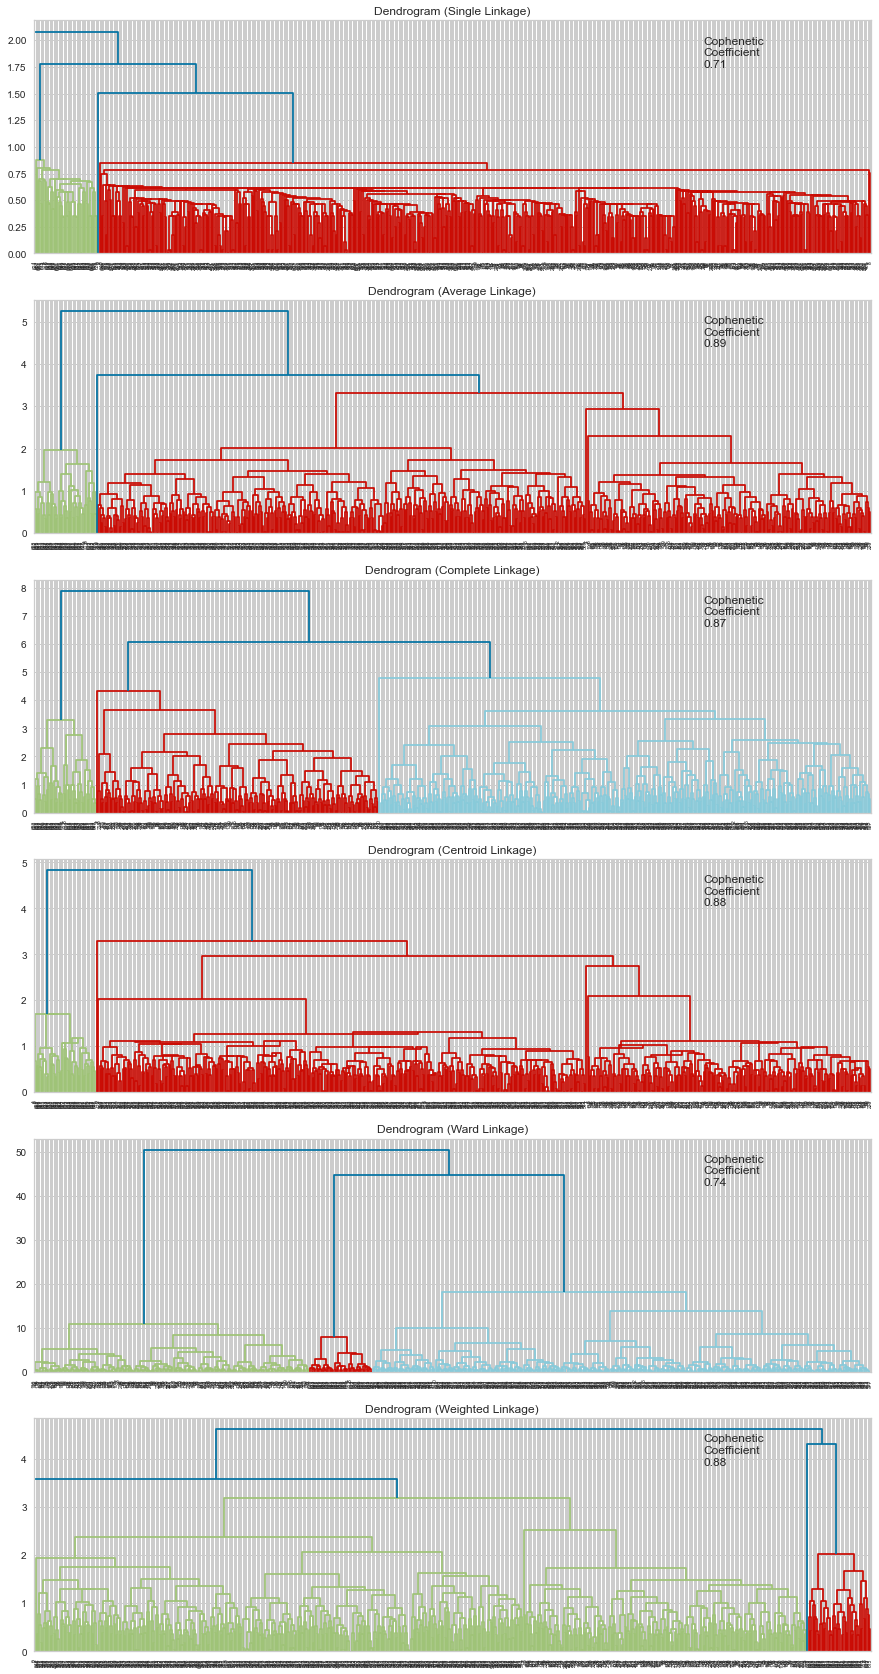

In [78]:
# List of all linkage methods to check
methods = ['single',
           'average', 
           'complete',
           'centroid',
           'ward',
          'weighted']

# Calculate the pairwise distance form the dataset to be used in the cophenetic correlation calculation

# Create lists to save results of coph calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
compare = []

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(15, 30))

# Enumerate through the list of all methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(methods):
    
    Z = linkage(subset_scaled_df2, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df2))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')
    compare.append([method, coph_corr])


Observations:
- Dendrogram with single and  ward linkage method are showing distinct and separate clusters.

In [79]:
# Create and print dataframe to compare Cophenetic Coefficient for each linkage
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc

Linkage  Cophenetic Coefficient
0    single                0.705359
1   average                0.890286
2  complete                0.866829
3  centroid                0.884713
4      ward                0.743378
5  weighted                0.875325

#### Let us see the dendrogram of 'mahalanobis','cityblock' with 'average', 'weighted' linkage method as they gave high cophenetic correlation value

In [80]:
distance_metrics = [ 'mahalanobis','cityblock','chebyshev']
linkage_methods = ['average', 'weighted']

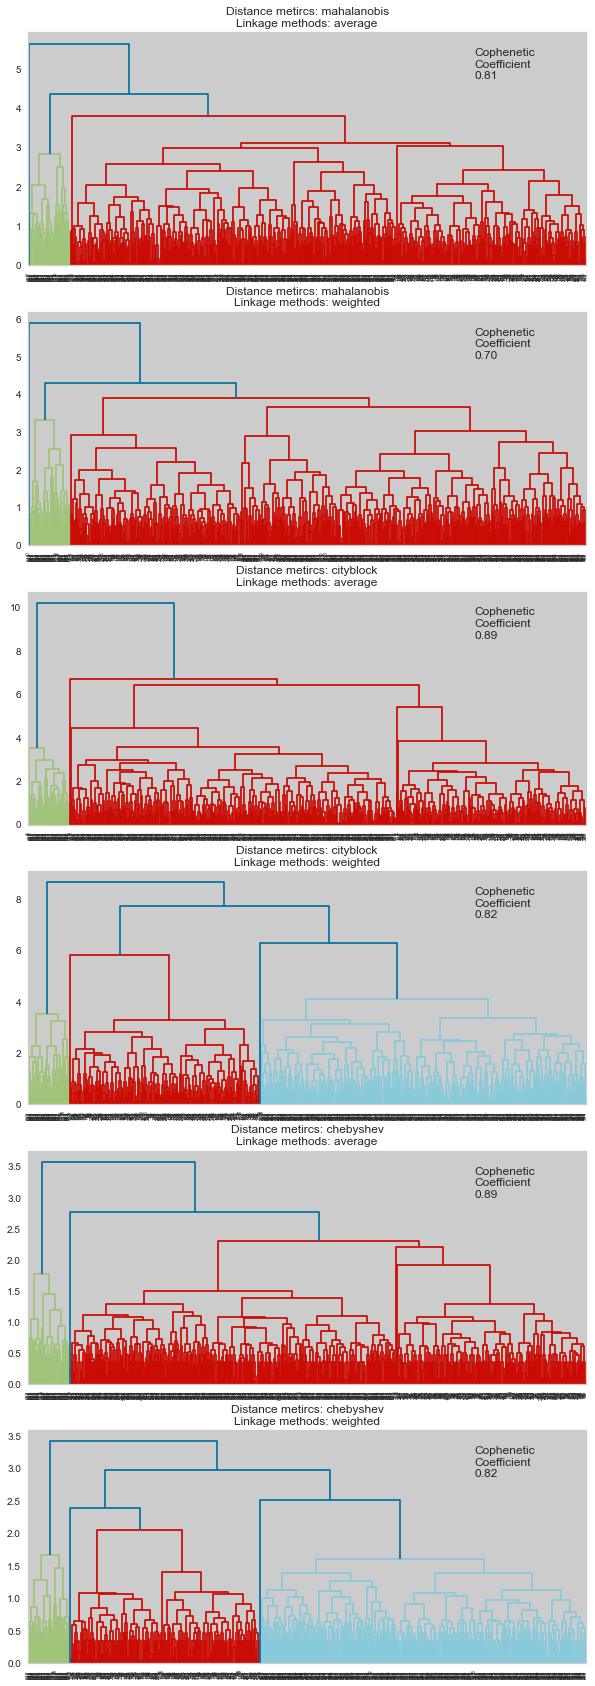

In [81]:
# Create a subplot image
fig, axs = plt.subplots(len(distance_metrics)+len(distance_metrics), 1, figsize=(10, 30))
i=0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df2, metric=dm, method=lm)
        dendrogram(Z,  ax=axs[i]);
        axs[i].set_title('Distance metircs: {}\nLinkage methods: {}'.format(dm,lm))
        coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df2))
        axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                        (0.80, 0.80),
                        xycoords='axes fraction')
        axs[i].set_title('Distance metircs: {}\nLinkage methods: {}'.format(dm,lm))                        
        i +=1
       


Observations:

- Out of all the dendrogram we saw, it is clear that dendrogram with weighted linkage method gave us separate and distinct clusters
- 3 cluster would be appropriate number of cluster from dendrogram with weighted linkage method

### Let us create 3 clusters

In [82]:
#Trying with 3 clusters
HCmodel = AgglomerativeClustering(n_clusters=3,affinity='euclidean', linkage='single')
HCmodel.fit(subset_scaled_df2)
subset_scaled_df2['HC_Clusters'] = HCmodel.labels_
CreditCardData['HC_Clusters'] = HCmodel.labels_
cluster_profile1 = CreditCardData.iloc[:,1:].groupby('HC_Clusters').mean()
cluster_profile1['count_in_each_segments'] = CreditCardData.groupby('HC_Clusters')['Total_Credit_Cards'].count().values

In [83]:
# lets display cluster profile
cluster_profile1.style.highlight_max(color = 'lightgreen', axis = 0)

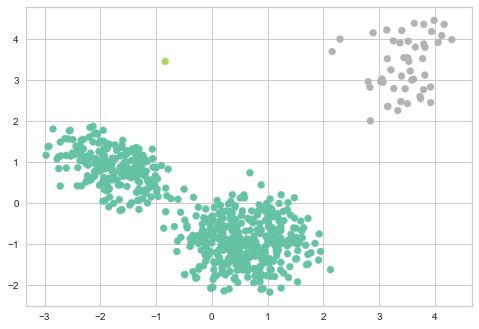

In [84]:
from sklearn.decomposition import PCA
import pylab as pl
pca=PCA(n_components=3).fit(subset_scaled_df2)
pca_2d=pca.transform(subset_scaled_df2)
pl.figure("HCmodels with 3 clusters")
pl.scatter(pca_2d[:,0],pca_2d[:,1],c=HCmodel.labels_,cmap='Set2')
pl.show();

We notice that there is only one record in one cluster with single linkage method. Lets try Ward Linkage method.

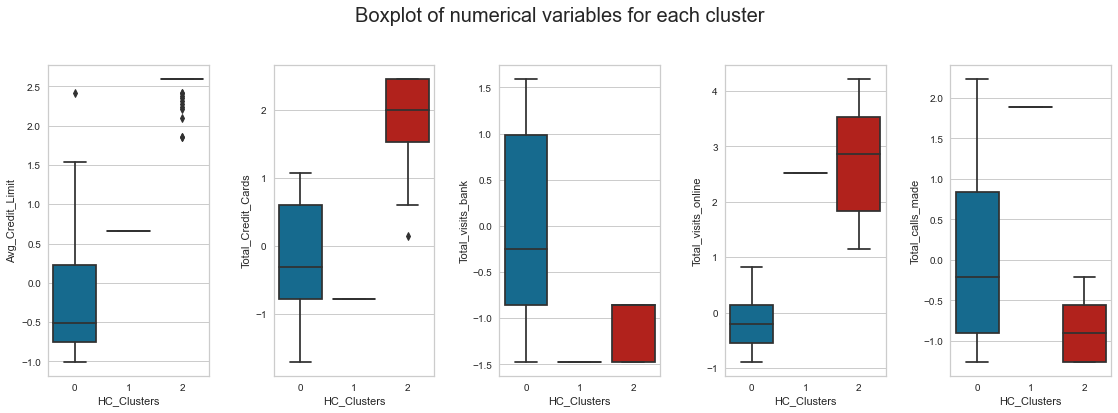

In [85]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=subset_scaled_df2[all_col[counter]],x=subset_scaled_df2['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

## Insights from Single Linkage Method:
#### Cluster 0  (Silver Customers):
* Avg Credit limit is less for this cluster
* Total credit cards taken by customers on an average is medium.
* Total Visits to the bank is high.
* Total Visits online is lowest as minimum as 2.
* Total calls made is medium.

#### Cluster 1 (Gold Customers):
* Avg Credit limit is medium for this cluster.
* Total credit cards taken by customers on an average is less.
* Total Visits to the bank is zero.
* Total Visits online is high, on an average 10 visits.
* Total calls made is high.

#### Cluster 2 (Platinum Customers):
* Avg Credit limit is high for this cluster.
* Total credit cards taken by customers on an average very high.
* Total Visits to the bank is very low.
* Total Visits online is highest, on an average 11 visits.
* Total calls made is lowest.


# Business Recommendations:
### Platinum Customers - 
Avg Credit limit and Total credit cards taken by customers on an average is very high.
These customers prefer online visits over phone call and bank visits.

#### Recommendation – 
- These customers already have more than average number of cards. AllLife bank should not focus on upselling to these customers, but rather focus on improving the customer service to retain them.

### Silver Customers - 
Avg Credit limit of customers on an average is very low and total number of credit cards taken is medium.
These customers prefer bank visits over Online and phone calls.

#### Recommendations- 
- These Customers prefer personal visits to the bank. AllLife bank can improve the customer experience by Encouraging customers to schedule appointments to reduce wait times.
- In addition to improving the customer service, AllLife bank can provide additional perks to customers who own greater number of credit cards to encourage existing customers to apply for more credit cards. 


### Gold Customers - 
Avg Credit limit of customers on an average is very medium and total number of credit cards taken is less.
These customers prefer Online banking and phone calls over bank visits.

#### Recommendations-
- These customers have the lowest number of credit cards; there is an opportunity to sell them more by improving their experience with the bank.
- Investing on an app is also a good idea to attract new customers who prefer mobile banking. 
- AllLife bank should hire multilingual representatives to cater to customers who speak different languages. 

In [86]:
CreditCardData = CreditCardData.drop('HC_Clusters',axis=1).copy()
subset_scaled_df2 = subset_scaled_df2.drop('HC_Clusters',axis=1).copy()

In [87]:
#Trying with 4 clusters
HCmodel = AgglomerativeClustering(n_clusters=4,affinity='euclidean', linkage='ward')
HCmodel.fit(subset_scaled_df2)
subset_scaled_df2['HC_Clusters'] = HCmodel.labels_
CreditCardData['HC_Clusters'] = HCmodel.labels_
cluster_profile1 = CreditCardData.iloc[:,1:].groupby('HC_Clusters').mean()
cluster_profile1['count_in_each_segments'] = CreditCardData.groupby('HC_Clusters')['Total_Credit_Cards'].count().values

In [88]:
# lets display cluster profile
cluster_profile1.style.highlight_max(color = 'lightgreen', axis = 0)

With 4 clusters, there is an overlap between values from cluster 0 and cluster 3.
Therefore, 3 clusters would be appropriate.

In [89]:
CreditCardData = CreditCardData.drop('HC_Clusters',axis=1).copy()
subset_scaled_df2 = subset_scaled_df2.drop('HC_Clusters',axis=1).copy()

In [90]:
#Trying with 3 clusters
HCmodel = AgglomerativeClustering(n_clusters=3,affinity='euclidean', linkage='ward')
HCmodel.fit(subset_scaled_df2)
subset_scaled_df2['HC_Clusters'] = HCmodel.labels_

In [91]:
CreditCardData['HC_Clusters'] = HCmodel.labels_

In [92]:
cluster_profile = CreditCardData.iloc[:,1:].groupby('HC_Clusters').mean()

In [93]:
cluster_profile['count_in_each_segments'] = CreditCardData.groupby('HC_Clusters')['Total_Credit_Cards'].count().values

In [94]:
# lets display cluster profile
cluster_profile.style.highlight_max(color = 'lightgreen', axis = 0)

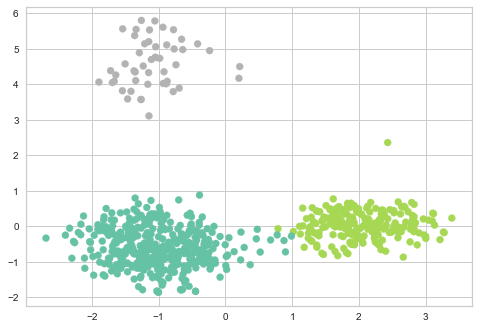

In [95]:
from sklearn.decomposition import PCA
import pylab as pl
pca=PCA(n_components=3).fit(subset_scaled_df2)
pca_2d=pca.transform(subset_scaled_df2)
pl.figure("HCmodels with 3 clusters")
pl.scatter(pca_2d[:,0],pca_2d[:,1],c=HCmodel.labels_,cmap='Set2')
pl.show();

We notice that 3 distinct clusters are formed with no overlapping and the results are almost similar to K-Means.

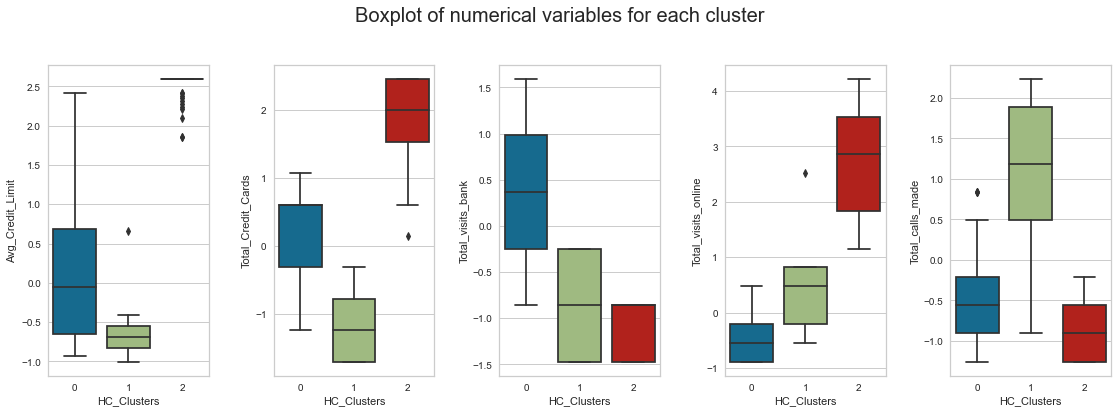

In [96]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=subset_scaled_df2[all_col[counter]],x=subset_scaled_df2['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

In [97]:
pd.crosstab(CreditCardData['HC_Clusters'], CreditCardData.Total_Credit_Cards).style.highlight_max(color = 'lightgreen', axis = 0)

## Insights from Ward Linkage Method:
#### Cluster 0  (Gold Customers):
* Avg Credit limit is medium for this cluster
* Total credit cards taken by customers on an average is medium.
* Total Visits to the bank is high.
* Total Visits online is lowest as minimum as 1.
* Total calls made is medium.

#### Cluster 1 (Silver Customers):
* Avg Credit limit is low for this cluster.
* Total credit cards taken by customers is less.
* Total Visits to the bank is medium.
* Total Visits online is medium, on an average 3 visits.
* Total calls made is high.

#### Cluster 2 (Platinum Customers):
* Avg Credit limit is high for this cluster.
* Total credit cards taken by customers on an average very high.
* Total Visits to the bank is very low.
* Total Visits online is highest, on an average 11 visits.
* Total calls made is lowest.


#### Lets compare Cluster vs Total_Credit_Cards

In [98]:
pd.crosstab(CreditCardData['HC_Clusters'], CreditCardData.Total_Credit_Cards).style.highlight_max(color = 'lightgreen', axis = 0)

Observations:
- There are more customers in cluster 0 with 4-7 Credit cards
- There are more customers in cluster 1 with 1-3 creditcards
- There are more customers in cluster 2 with 8-10 creditcards.

## Cluster Comparisions

- K-Means and Hierarchical Clustering- Ward Linkage Methods shows similar results. 
- However, Hierarchical Clustering – Single Linkage method gives different set of clusters with different averages and different grouping. The variance in one group is extremely high and there is no uniform distribution and there seems to be an overlap in total visits online from cluster 1 and 2.

- In “Platinum Customer” cluster, 49 customers are identified as platinum customers in all the methods.
- In “Gold Customer” cluster, 382 potential members are identified through K- Means clustering  method and 390 members through Hierarchical clustering-Ward Linkage method and 605 customers in Hierarchical clustering- Single Linkage method .
- In “Silver Customer” cluster, 224 members are identified through K- Means clustering  method and 216 members through Hierarchical clustering method and 1 customer in Hierarchical clustering-Single Linkage method .

- The differences in Gold and Silver Clusters from both the K-Means and Hierarchical Clustering- Ward Linkage Methods are very close. 
- As we know, k-means algorithms assume that clusters are spherical in shapes but that is not the assumption of HC algorithm.

- K-Means clustering  gave us a fast solution on k value without much workaround, though we had to initialize and try on multiple k values.
- With K-Means clustering, both Elbow method and Silhouette score confirmed that k value=3 is apt.

- However, there was little workaround with Hierarchical clustering to conclude on number of clusters as the single linkage method lead us with one of the clusters with a  single record which doesn’t seem to be appropriate as there is an overlap in some values and thereby, we had to choose ward linkage method. With ward linkage method, we had to try both 4 clusters and 3 clusters and then conclude on 3 clusters as there was an overlap between values with 4 clusters.

##### Therefore K-Means Clustering method worked well for this dataset.

## PCA

### Bartletts Test of Sphericity
Checks for reasonable correlation between the observed variables. PCA is applied if there is a significant correlation.

If Null Hypothesis is rejected it means there is a significant correlation and PCA can be applied.

Hence we expect p-value < 0.05 from the test to proceed further

In [99]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(CreditCardData)
p_value

0.0

### KMO Test
It used to check for sample adequecy before proceeding with PCA

KMO of greater than 0.5 indicates that sample size is adequate for getting the components

In [100]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(CreditCardData)
kmo_model

0.7086822377056096

From Bartletts Test of Sphericity and KMO Test, PCA can be applied on this dataset.

In [101]:
subset_scaled_df3 = subset_scaled_df2.drop('HC_Clusters',axis=1).copy()

In [102]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(subset_scaled_df3)

PCA()

In [103]:
# Show variance explained by individual components
pca.explained_variance_ratio_

array([0.46564403, 0.35223138, 0.06517441, 0.06239912, 0.05455106])

Text(0, 0.5, 'Cumulative Explained Variance')

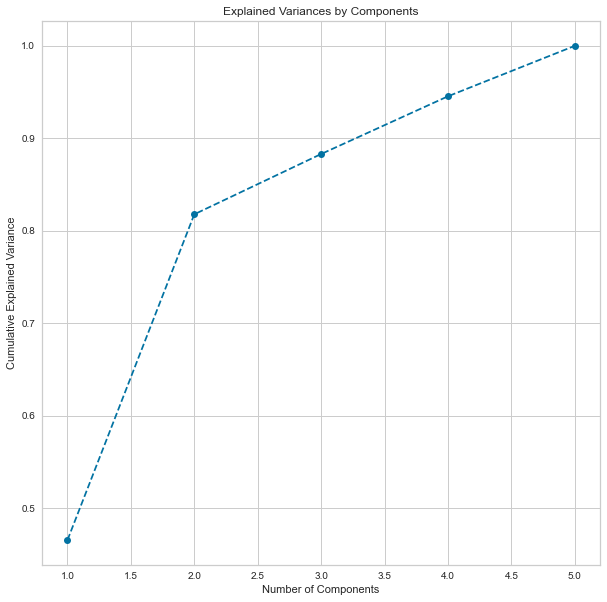

In [104]:
# visulaize the Explained Individual Components
plt.figure(figsize = (10,10))
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [105]:
pca = PCA(.9,svd_solver ='full') # svd_solver -full helps to converge faster in case of very large data set
pca.fit(subset_scaled_df3)

PCA(n_components=0.9, svd_solver='full')

In [106]:
pca.explained_variance_

array([2.3317801 , 1.76384978, 0.32637034, 0.31247268])

Text(0, 0.5, 'Cumulative Explained Variance')

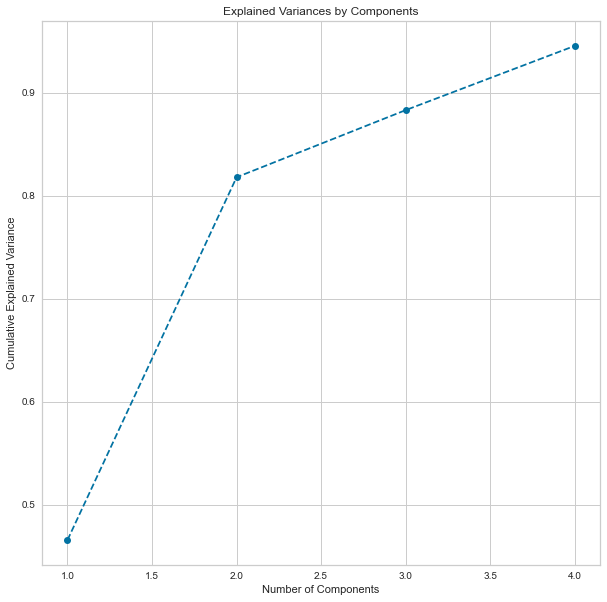

In [107]:
plt.figure(figsize = (10,10))
plt.plot(range(1,5), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [108]:
subset_pca = pca.transform(subset_scaled_df3)
subset_pca = pd.DataFrame(subset_pca)

### Perform Clustering


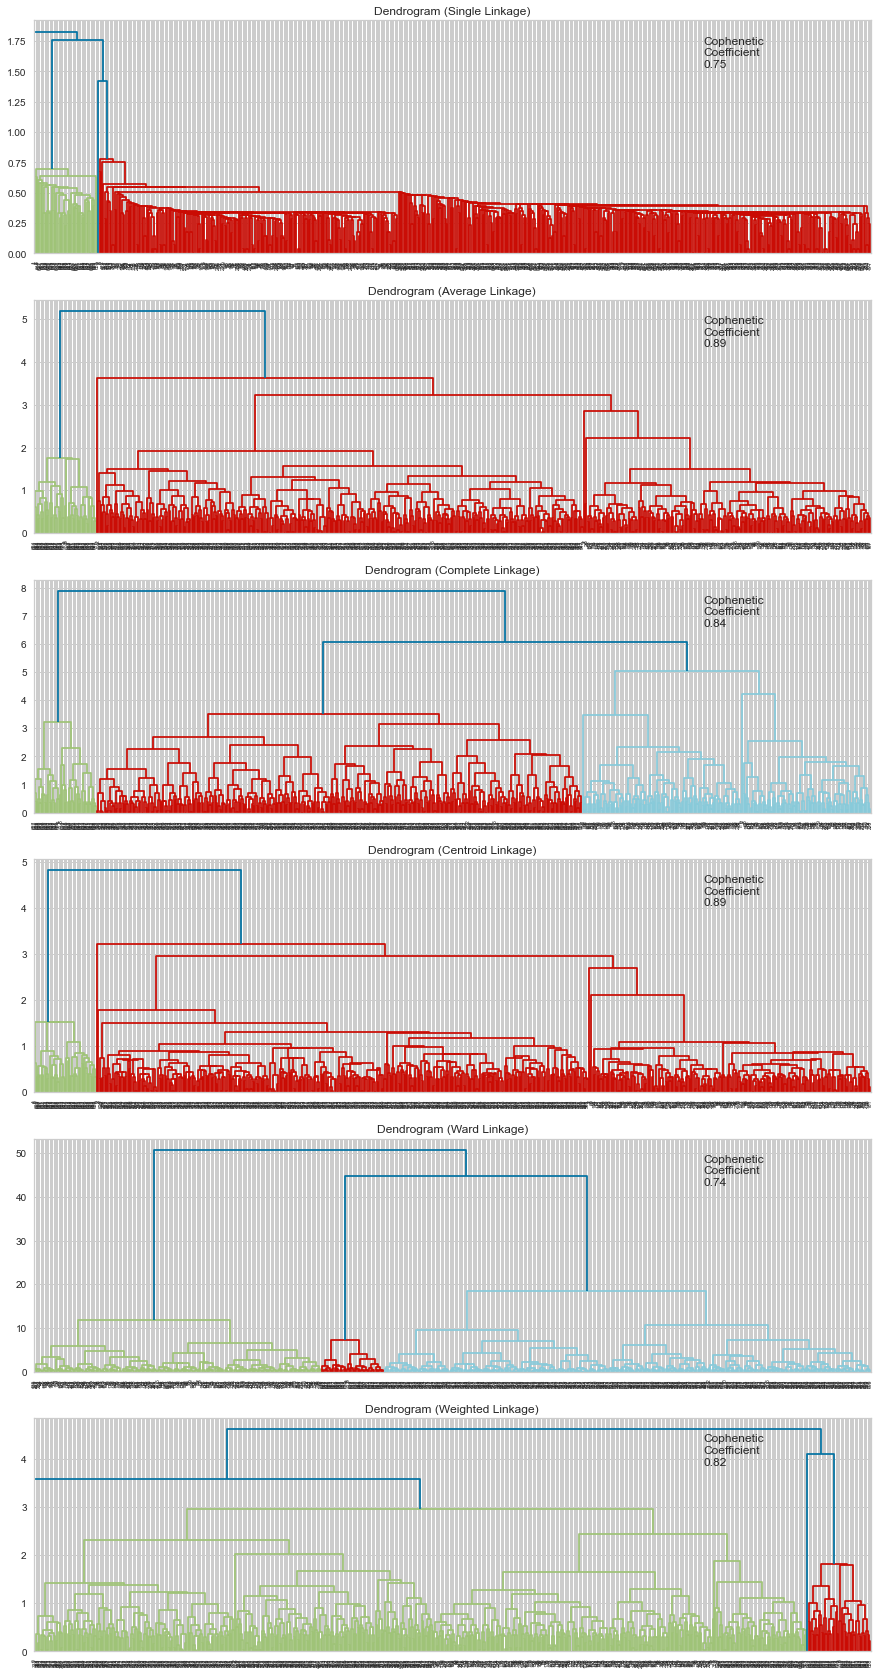

In [109]:
# List of all linkage methods to check
methods = ['single',
           'average', 
           'complete',
           'centroid',
           'ward',
          'weighted']

# Calculate the pairwise distance form the dataset to be used in the cophenetic correlation calculation
#pw_distance = pdist(credit_scaled)

# Create lists to save results of coph calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
# compare = []

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(15, 30))

# Enumerate through the list of all methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(methods):
    
    Z = linkage(subset_pca, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df3))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')
#     compare.append([method, coph_corr])


It can be seen that ward linkage method show 3 as apt number of clusters

In [110]:
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
hc_labels = hc.fit_predict(subset_pca)

In [111]:
CreditCardData['PCA_HC_clusters'] = hc_labels

In [112]:
cluster_profile2 = CreditCardData.iloc[:,1:].groupby('PCA_HC_clusters').mean()
cluster_profile2['count_in_each_segments'] = CreditCardData.groupby('PCA_HC_clusters')['Total_Credit_Cards'].count().values

In [113]:
# lets see names of countries in each cluster
for cl in CreditCardData['PCA_HC_clusters'].unique():

    print(CreditCardData[CreditCardData['PCA_HC_clusters']==cl]['Total_Credit_Cards'].unique())

[2 7 5 4 6]
[3 2 4 1 5]
[ 6  5  9  8 10  7]


In [114]:
# lets display cluster profile
cluster_profile2.style.highlight_max(color = 'lightgreen', axis = 0)


# Business Recommendations:
### Platinum Customers - 
Avg Credit limit and Total credit cards taken by customers on an average is very high.
These customers prefer online visits over phone call and bank visits.

#### Recommendation – 
- These customers already have more than average number of cards. AllLife bank should not focus on upselling to these customers, but rather focus on improving the customer service to retain them.
- These customers prefer online banking, so AllLife should focus on improving the user userface to improve customer experience. It is also recommended that the bank uses surveys to get feedback from these customers and continually improve the FAQs section to answer all the questions.
- It is also recommended to provide 24x7 online customer support in the form of live chat and emails. AllLife bank can also distinguish itself from other banks by providing a guaranteed response within a short window.
- The platinum customers own a large number of credit cards and can be great ambassadors to the bank to attract newer customers through referrals. AllLife bank should provide incentives to these customers for providing referrals.
- Investing on an app is also a good idea to attract new customers who prefer mobile banking. 

### Silver Customers - 
Avg Credit limit and Total credit cards taken by customers on an average is very low.
These customers prefer phone calls over Online and bank visits.

#### Recommendations- 
- These customers have the lowest number of credit cards; there is an opportunity to sell them more by improving their experience with the bank. AllLife bank should, therefore, train the customer service representatives and empower them to resolve the customer issues to reduce the number of phone calls and the time needed to resolve the issues. 
- In addition to improving the customer service, AllLife bank can provide additional perks to customers who own greater number of credit cards to encourage existing customers to apply for more credit cards. 
- AllLife bank should hire multilingual representatives to cater to customers who speak different languages. 

### Gold Customers - 
Avg Credit limit and Total credit cards taken by customers on an average is medium.
These customers prefer bank visits over phone calls and online.

#### Recommendations-
- The Gold Customers prefer personal visits to the bank. AllLife bank can improve the customer experience by Encouraging customers to schedule appointments to reduce wait times.
- Building a luxury lounge in the bank with amenities (TVs, coffee, internet) for walk in (no appointment) customers while they wait for service.
- Following up with the customers after their visit to check if their issues have been resolved. This provides AllLife representatives an opportunity to address any unresolved issues and improve customer experience and loyalty. 
